# Install packages

In [0]:
!pip install openpyxl

Collecting openpyxl
 Downloading openpyxl-3.0.9-py2.py3-none-any.whl (242 kB)
█▍ | 10 kB 35.6 MB/s eta 0:00:01 |██▊ | 20 kB 39.2 MB/s eta 0:00:01 |████ | 30 kB 38.5 MB/s eta 0:00:01 |█████▍ | 40 kB 24.1 MB/s eta 0:00:01 |██████▊ | 51 kB 19.9 MB/s eta 0:00:01 |████████▏ | 61 kB 22.9 MB/s eta 0:00:01 |█████████▌ | 71 kB 24.7 MB/s eta 0:00:01 |██████████▉ | 81 kB 24.6 MB/s eta 0:00:01 |████████████▏ | 92 kB 26.7 MB/s eta 0:00:01 |█████████████▌ | 102 kB 28.6 MB/s eta 0:00:01 |██████████████▉ | 112 kB 28.6 MB/s eta 0:00:01 |████████████████▎ | 122 kB 28.6 MB/s eta 0:00:01 |█████████████████▋ | 133 kB 28.6 MB/s eta 0:00:01 |███████████████████ | 143 kB 28.6 MB/s eta 0:00:01 |████████████████████▎ | 153 kB 28.6 MB/s eta 0:00:01 |█████████████████████▋ | 163 kB 28.6 MB/s eta 0:00:01 |███████████████████████ | 174 kB 28.6 MB/s eta 0:00:01 |████████████████████████▍ | 184 kB 28.6 MB/s eta 0:00:01 |█████████████████████████▊ | 194 kB 28.6 MB/s eta 0:00:01 |███████████████████████████ | 204 kB 28.6 MB/s eta 0:00:01 |████████████████████████████▍ | 215 kB 28.6 MB/s eta 0:00:01 |█████████████████████████████▊ | 225 kB 28.6 MB/s eta 0:00:01 |███████████████████████████████▏| 235 kB 28.6 MB/s eta 0:00:01 |████████████████████████████████| 242 kB 28.6 MB/s 
Collecting et-xmlfile
 Downloading et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Installing collected packages: et-xmlfile, openpyxl
Successfully installed et-xmlfile-1.1.0 openpyxl-3.0.9
 WARNING: You are using pip version 21.0.1; however, version 22.0.4 is available.
You should consider upgrading via the '/databricks/python3/bin/python -m pip install --upgrade pip' command.

# Import packages

In [0]:
import io
import os
import requests

import pandas as pd
from PIL import Image, ImageFile
from tqdm import tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set paths

In [0]:
root = "/dbfs/sketches"
img_path = "images"
label_path = "Training_data_Jan2022.xlsx"
label_file1 = "sketches_mlmc.csv"
label_file2 = "sketches_mc.csv"

fill_str = "None"

# Read data

In [0]:
sketch_df = pd.read_excel(os.path.join(root, label_path))
sketch_df.head()

Out[5]:

,Image URL,Image Name,Image Id,Product Number,Type,Garment group,Category,SubCategory,Department Name,Customer Group,Seasonold,UniquieVal
0,https://imagebankstorageprd.blob.core.windows....,PLUS-SIZE-Support-40-DEN-1p-Tights-black-beige...,1094774,561274,Underwear Tights,Socks & Tights,Shaping level,Light shape,3608 - Tights basic,Ladies,04-2021,Socks & Tights:Underwear Tights:Shaping level:...
1,https://imagebankstorageprd.blob.core.windows....,PLUS-SIZE-Support-40-DEN-1p-Tights-black-beige...,1094774,561274,Underwear Tights,Socks & Tights,Waist rise,High waist,3608 - Tights basic,Ladies,04-2021,Socks & Tights:Underwear Tights:Waist rise:Hig...
2,https://imagebankstorageprd.blob.core.windows....,NILS-BASIC-2PK.png,1117909,768913,Sweater,Garment Upper body,Front closure,Button,6546 - Baby Boy Knitwear,Kids,03-2021,Garment Upper body:Sweater:Front closure:Button
3,https://imagebankstorageprd.blob.core.windows....,SUPPORT-TIGHTS-100DEN-black.png,1132415,417951,Underwear Tights,Socks & Tights,Shaping level,Medium shape,3608 - Tights basic,Ladies,03-2021,Socks & Tights:Underwear Tights:Shaping level:...
4,https://imagebankstorageprd.blob.core.windows....,SUPPORT-TIGHTS-100DEN-black.png,1132415,417951,Underwear Tights,Socks & Tights,Waist rise,High waist,3608 - Tights basic,Ladies,03-2021,Socks & Tights:Underwear Tights:Waist rise:Hig...


In [0]:
print(f"Unique URL's {sketch_df['Image URL'].nunique()}")
print(f"Unique ID's {sketch_df['Image Id'].nunique()}")
print(f"Unique Product number's {sketch_df['Product Number'].nunique()}")
print(f"Unique Name's {sketch_df['Image Name'].nunique()}")

Unique URL's 20111
Unique ID's 20122
Unique Product number's 8961
Unique Name's 19918

# Download data

In [0]:
def fetch_images(data: pd.DataFrame, dir_path: str, img_path: str) -> None:
    """Fetch images given the dataframe of urls and image id's
    Args:
        data: Input dataframe containing image urls and id's
        dir_path: Root directory
        img_path: Path to save images to
    """
    tot_url = len(data)
    tot_id = data["Image Id"].nunique()

    cnt_downloaded, cnt_exists, cnt_resp_err = 0, 0, 0
    for _, row in tqdm(data.iterrows(), unit="rows", total=tot_url):
        url = row["Image URL"]
        id_ = row["Image Id"]
        file_name = os.path.join(dir_path, img_path, f"{id_}.jpg")
        if not os.path.isfile(file_name):
            try:
                response = requests.get(url)
                if response.status_code == 200:
                    with Image.open(io.BytesIO(response.content)) as img:
                        try:
                            img.convert("RGB").save(file_name)
                        except OSError:
                            img.convert("RGB").save(file_name)
                    cnt_downloaded += 1
                else:
                    cnt_resp_err += 1
            except requests.exceptions.RequestException as e:
                raise SystemExit(e)
        else:
            cnt_exists += 1

    print(f"Images downloaded: {cnt_downloaded}!")
    print(f"Non existent urls: {cnt_resp_err}!")
    print(f"Images already exist: {cnt_exists}!")

## Fix Id's

In [0]:
fetch_data = sketch_df.groupby("Image URL").first().reset_index()
print(f"Unique URL's: {fetch_data.shape}")
fetch_data = fetch_data[~(fetch_data["Image URL"] == "Image not found")]
print(f"Valid unique URL's: {fetch_data.shape}")

Unique URL's: (20111, 12)
Valid unique URL's: (20110, 12)

In [0]:
print(f"Unique URL's {fetch_data['Image URL'].nunique()}")
print(f"Unique ID's {fetch_data['Image Id'].nunique()}")

Unique URL's 20110
Unique ID's 20108

In [0]:
mask = fetch_data["Image Id"].duplicated()
fetch_data["Image Id"] = fetch_data["Image Id"].astype("str")
fetch_data.loc[mask, "Image Id"] += "_1"

In [0]:
print(f"Unique URL's {fetch_data['Image URL'].nunique()}")
print(f"Unique ID's {fetch_data['Image Id'].nunique()}")

Unique URL's 20110
Unique ID's 20110

## Download

In [0]:
os.makedirs(os.path.join(root, img_path), exist_ok=True)
fetch_images(fetch_data, root, img_path)

0%| | 0/20110 [00:00<?, ?rows/s] 0%| | 2/20110 [00:00<22:02, 15.21rows/s] 0%| | 10/20110 [00:00<07:09, 46.76rows/s] 0%| | 23/20110 [00:00<04:10, 80.27rows/s] 0%| | 37/20110 [00:00<03:19, 100.62rows/s] 0%| | 52/20110 [00:00<02:55, 114.00rows/s] 0%| | 65/20110 [00:00<03:27, 96.76rows/s]  0%| | 76/20110 [00:00<03:36, 92.39rows/s] 0%| | 89/20110 [00:00<03:16, 101.85rows/s] 0%| | 100/20110 [00:01<03:16, 102.04rows/s] 1%| | 118/20110 [00:01<02:42, 123.27rows/s] 1%| | 135/20110 [00:01<02:27, 134.99rows/s] 1%| | 149/20110 [00:01<02:37, 127.14rows/s] 1%| | 165/20110 [00:01<02:27, 135.27rows/s] 1%| | 181/20110 [00:01<02:20, 141.97rows/s] 1%| | 201/20110 [00:01<02:07, 156.62rows/s] 1%| | 217/20110 [00:01<02:13, 148.91rows/s] 1%| | 233/20110 [00:01<02:20, 141.19rows/s] 1%| | 249/20110 [00:02<02:16, 145.90rows/s] 1%|▏ | 267/20110 [00:02<02:22, 139.65rows/s] 1%|▏ | 285/20110 [00:02<02:11, 150.26rows/s] 2%|▏ | 302/20110 [00:02<02:07, 155.45rows/s] 2%|▏ | 321/20110 [00:02<02:00, 163.65rows/s] 2%|▏ | 338/20110 [00:02<02:03, 160.65rows/s] 2%|▏ | 360/20110 [00:02<01:51, 176.59rows/s] 2%|▏ | 381/20110 [00:02<01:46, 185.87rows/s] 2%|▏ | 403/20110 [00:02<01:42, 192.61rows/s] 2%|▏ | 423/20110 [00:03<01:45, 187.26rows/s] 2%|▏ | 442/20110 [00:03<02:06, 155.67rows/s] 2%|▏ | 463/20110 [00:03<01:56, 168.28rows/s] 2%|▏ | 481/20110 [00:03<01:57, 166.60rows/s] 2%|▏ | 499/20110 [00:03<02:02, 159.78rows/s] 3%|▎ | 516/20110 [00:03<02:17, 142.39rows/s] 3%|▎ | 531/20110 [00:03<02:34, 127.05rows/s] 3%|▎ | 553/20110 [00:03<02:12, 148.11rows/s] 3%|▎ | 573/20110 [00:04<02:01, 160.80rows/s] 3%|▎ | 595/20110 [00:04<01:51, 174.83rows/s] 3%|▎ | 614/20110 [00:04<02:14, 144.80rows/s] 3%|▎ | 630/20110 [00:04<02:23, 135.36rows/s] 3%|▎ | 645/20110 [00:04<02:38, 122.46rows/s] 3%|▎ | 665/20110 [00:04<02:19, 139.14rows/s] 3%|▎ | 685/20110 [00:04<02:06, 153.72rows/s] 3%|▎ | 702/20110 [00:04<02:11, 147.16rows/s] 4%|▎ | 718/20110 [00:05<02:09, 149.64rows/s] 4%|▎ | 734/20110 [00:05<02:39, 121.46rows/s] 4%|▎ | 749/20110 [00:05<02:33, 126.47rows/s] 4%|▍ | 770/20110 [00:05<02:11, 147.12rows/s] 4%|▍ | 786/20110 [00:05<02:11, 146.58rows/s] 4%|▍ | 802/20110 [00:05<02:12, 145.85rows/s] 4%|▍ | 822/20110 [00:05<02:01, 158.71rows/s] 4%|▍ | 841/20110 [00:05<01:55, 166.46rows/s] 4%|▍ | 864/20110 [00:06<01:44, 183.93rows/s] 4%|▍ | 885/20110 [00:06<01:41, 189.07rows/s] 5%|▍ | 908/20110 [00:06<01:35, 200.53rows/s] 5%|▍ | 930/20110 [00:06<01:33, 204.93rows/s] 5%|▍ | 953/20110 [00:06<01:31, 210.04rows/s] 5%|▍ | 977/20110 [00:06<01:28, 217.04rows/s] 5%|▍ | 1000/20110 [00:06<01:26, 220.19rows/s] 5%|▌ | 1024/20110 [00:06<01:25, 223.84rows/s] 5%|▌ | 1047/20110 [00:06<01:34, 201.01rows/s] 5%|▌ | 1069/20110 [00:06<01:32, 206.09rows/s] 5%|▌ | 1090/20110 [00:07<01:32, 206.00rows/s] 6%|▌ | 1111/20110 [00:07<01:40, 188.25rows/s] 6%|▌ | 1131/20110 [00:07<01:48, 174.16rows/s] 6%|▌ | 1153/20110 [00:07<01:42, 184.19rows/s] 6%|▌ | 1172/20110 [00:07<01:52, 167.72rows/s] 6%|▌ | 1191/20110 [00:07<01:49, 172.45rows/s] 6%|▌ | 1211/20110 [00:07<02:40, 117.70rows/s] 6%|▌ | 1231/20110 [00:08<02:21, 133.12rows/s] 6%|▌ | 1255/20110 [00:08<02:01, 155.72rows/s] 6%|▋ | 1274/20110 [00:08<02:01, 154.60rows/s] 6%|▋ | 1295/20110 [00:08<01:52, 167.12rows/s] 7%|▋ | 1319/20110 [00:08<01:41, 184.57rows/s] 7%|▋ | 1341/20110 [00:08<01:36, 193.99rows/s] 7%|▋ | 1362/20110 [00:08<01:36, 193.34rows/s] 7%|▋ | 1383/20110 [00:08<01:42, 183.12rows/s] 7%|▋ | 1405/20110 [00:08<01:37, 191.81rows/s] 7%|▋ | 1425/20110 [00:09<01:42, 181.86rows/s] 7%|▋ | 1444/20110 [00:09<02:03, 150.84rows/s] 7%|▋ | 1461/20110 [00:09<02:01, 153.09rows/s] 7%|▋ | 1483/20110 [00:09<02:00, 154.03rows/s] 7%|▋ | 1505/20110 [00:09<01:49, 170.19rows/s] 8%|▊ | 1523/20110 [00:09<01:53, 163.16rows/s] 8%|▊ | 1541/20110 [00:09<01:51, 167.14rows/s] 8%|▊ | 1564/20110 [00:09<01:41, 182.62rows/s] 8%|▊ | 1583/20110 [00:10<01:49, 169.90rows/s] 8%|▊ | 1601/20110 [00:10<02:13, 139.02rows/s] 8%|▊ | 1624

In [0]:
file_list = os.listdir(os.path.join(root, img_path))
print(f"Number of images: {len(file_list)}")

Number of images: 19788

# Create labels

In [0]:
del_cols = ["Image URL", "Image Name", "Product Number", "Garment group", "Department Name", "Seasonold", "UniquieVal"]
data = fetch_data.drop(del_cols, axis=1)
print(data.shape)
data.head()

(20110, 5)
Out[14]:

,Image Id,Type,Category,SubCategory,Customer Group
1,1856228,Jacket,Neckline,Round neck,Man
2,1934816,Underwear bottom,Garment length,None,Ladies
3,1851332,Dress,Fit,Loose fit,Ladies
4,1842000,Dress,Fit,Regular fit,Kids
5,1831500,Socks,Shaft height,Regular,Mix


In [0]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20110 entries, 1 to 20110
Data columns (total 5 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Image Id 20110 non-null object
 1 Type 20110 non-null object
 2 Category 19541 non-null object
 3 SubCategory 19541 non-null object
 4 Customer Group 20110 non-null object
dtypes: object(5)
memory usage: 942.7+ KB

## Fix nulls

In [0]:
data_clean = data.fillna(value=fill_str, axis=0)
data_clean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20110 entries, 1 to 20110
Data columns (total 5 columns):
 # Column Non-Null Count Dtype 
--- ------ -------------- ----- 
 0 Image Id 20110 non-null object
 1 Type 20110 non-null object
 2 Category 20110 non-null object
 3 SubCategory 20110 non-null object
 4 Customer Group 20110 non-null object
dtypes: object(5)
memory usage: 942.7+ KB

In [0]:
print(f"Numberof unique types: {data_clean['Type'].nunique()}")
print(f"Numberof unique category: {data_clean['Category'].nunique()}")
print(f"Numberof unique subcategory: {data_clean['SubCategory'].nunique()}")
print(f"Numberof unique customer group: {data_clean['Customer Group'].nunique()}")

Numberof unique types: 30
Numberof unique category: 26
Numberof unique subcategory: 172
Numberof unique customer group: 5

## Filter data

In [0]:
id_list = [f[:-4] for f in file_list]
data_filt = data_clean[data_clean["Image Id"].isin(id_list)]
data_filt.shape

Out[31]: (19788, 5)

## Check labels

Out[90]:

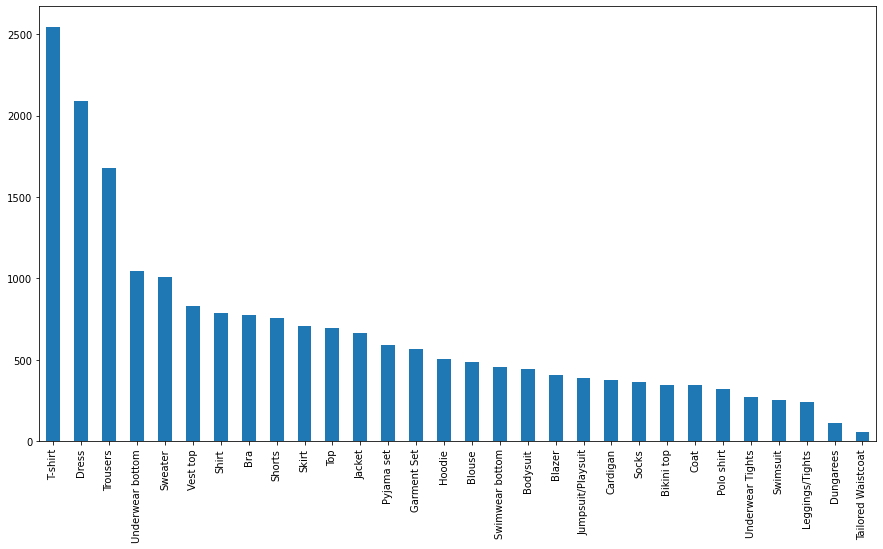

<AxesSubplot:>

In [0]:
type_vc = data_clean["Type"].value_counts()
type_vc.plot.bar(figsize=(15, 8))

Out[91]:

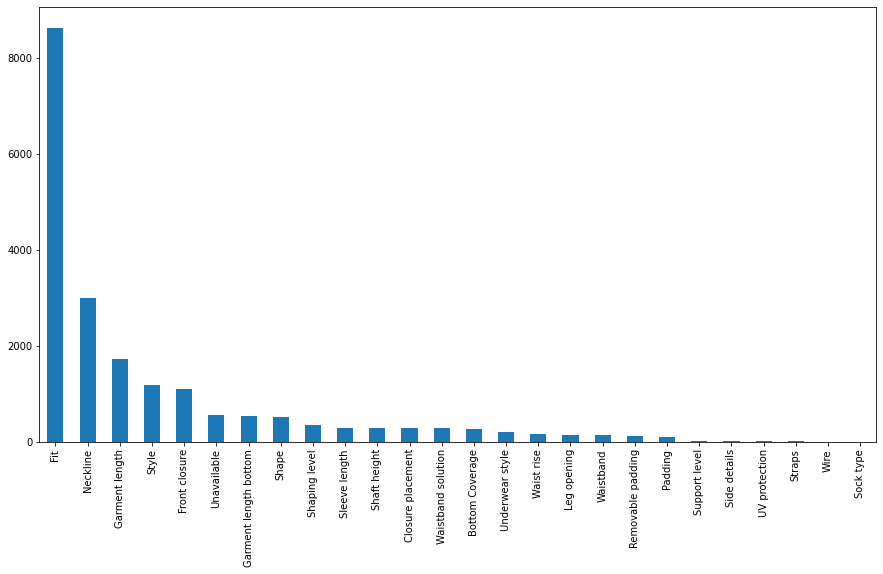

<AxesSubplot:>

In [0]:
cat_vc = data_clean["Category"].value_counts()
cat_vc.plot.bar(figsize=(15, 8))

Out[92]:

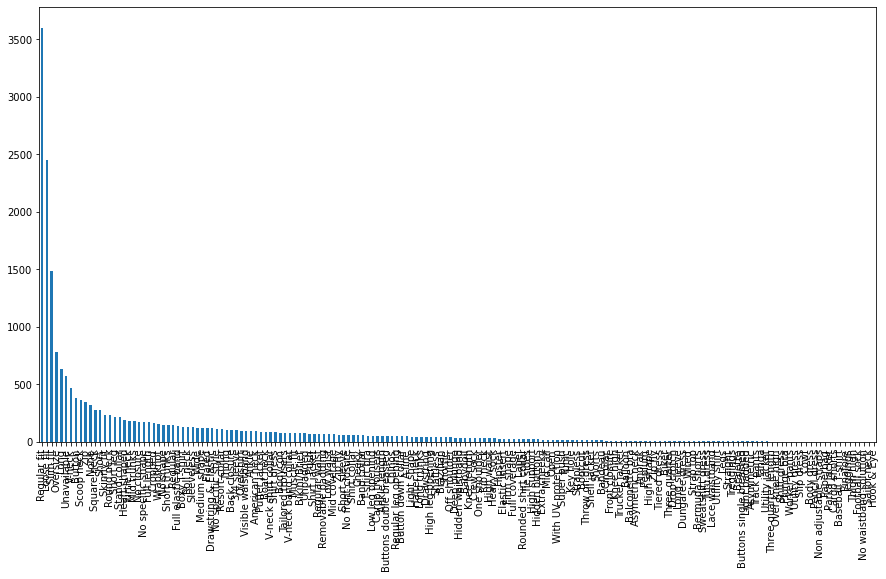

<AxesSubplot:>

In [0]:
scat_vc = data_clean["SubCategory"].value_counts()
scat_vc.plot.bar(figsize=(15, 8))

Out[93]:

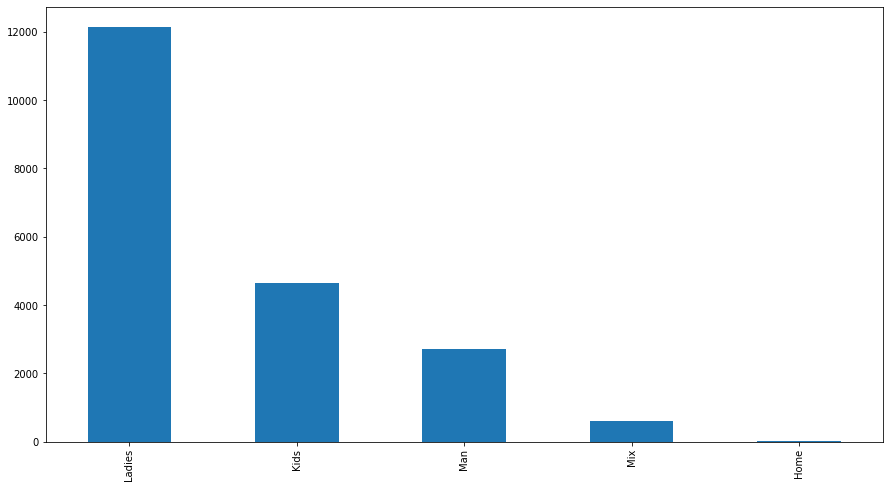

<AxesSubplot:>

In [0]:
cg_vc = data_clean["Customer Group"].value_counts()
cg_vc.plot.bar(figsize=(15, 8))

## Multi label Multi-class

In [0]:
out = pd.get_dummies(
    data_filt,
    columns=["Type", "Category", "SubCategory", "Customer Group"],
)
print(out.shape)
out.head()

(19788, 233)
Out[38]:

,Image Id,Type_Bikini top,Type_Blazer,Type_Blouse,Type_Bodysuit,Type_Bra,Type_Cardigan,Type_Coat,Type_Dress,Type_Dungarees,Type_Garment Set,Type_Hoodie,Type_Jacket,Type_Jumpsuit/Playsuit,Type_Leggings/Tights,Type_Polo shirt,Type_Pyjama set,Type_Shirt,Type_Shorts,Type_Skirt,Type_Socks,Type_Sweater,Type_Swimsuit,Type_Swimwear bottom,Type_T-shirt,Type_Tailored Waistcoat,Type_Top,Type_Trousers,Type_Underwear Tights,Type_Underwear bottom,Type_Vest top,Category_Bottom Coverage,Category_Closure placement,Category_Fit,Category_Front closure,Category_Garment length,Category_Garment length bottom,Category_Leg opening,Category_Neckline,Category_Padding,...,SubCategory_Strapless,SubCategory_Super push,SubCategory_Sweatshirt dress,SubCategory_T-shirt bra,SubCategory_Tailored trousers,SubCategory_Tanga,SubCategory_Thigh high,SubCategory_Thong,SubCategory_Three quarter,SubCategory_Three quarter length,SubCategory_Throw on dress,SubCategory_Tie sides,SubCategory_Tiered dress,SubCategory_Track pants,SubCategory_Treggings,SubCategory_Trucker jacket,SubCategory_Tunic,SubCategory_Turtle neck,SubCategory_Tutu dress,SubCategory_Unavailable,SubCategory_Unpadded,SubCategory_Utility dress,SubCategory_Utility jacket,SubCategory_Utility shirt,SubCategory_V-neck,SubCategory_V-neck band collar,SubCategory_V-neck shirt collar,SubCategory_Visible waistband,SubCategory_Wide,SubCategory_Wired,SubCategory_With UV protection,SubCategory_Worker pants,SubCategory_Wrap/knot,SubCategory_Zip,SubCategory_Zip fly,Customer Group_Home,Customer Group_Kids,Customer Group_Ladies,Customer Group_Man,Customer Group_Mix
1,1856228,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,1934816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,1851332,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,1842000,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,1831500,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
tmp = out.groupby("Image Id").sum()
assert (tmp > 1).any().any() == False
assert (tmp < 0).any().any() == False
assert (tmp == 0).all().any() == False
assert (tmp == 0).all(1).any() == False
assert (tmp.sum(1) > 1).all() == True
assert tmp.reset_index().shape == out.shape

### Write labels

In [0]:
out.to_csv(os.path.join(root, label_file1), index=False)

## Hierarchical

In [0]:
labels = pd.DataFrame(columns=["Image Id", "labels"])
labels["Image Id"] = data_filt["Image Id"]
labels["labels"] = data_filt[["Type", "Category", "SubCategory", "Customer Group"]].agg("-".join, axis=1)
print(labels.shape)
labels.head()

(19788, 2)
Out[73]:

,Image Id,labels
1,1856228,Jacket-Neckline-Round neck-Man
2,1934816,Underwear bottom-Garment length-None-Ladies
3,1851332,Dress-Fit-Loose fit-Ladies
4,1842000,Dress-Fit-Regular fit-Kids
5,1831500,Socks-Shaft height-Regular-Mix


Out[94]:

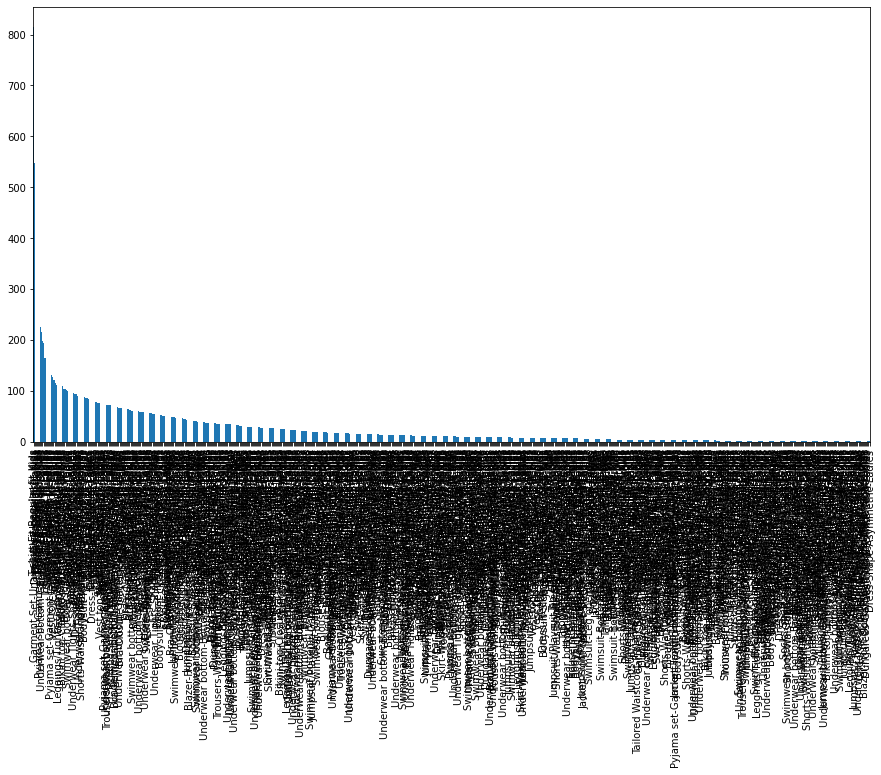

<AxesSubplot:>

In [0]:
l_vc = labels["labels"].value_counts()
l_vc.plot.bar(figsize=(15, 8))

In [0]:
labels["code"] = labels["labels"].astype("category").cat.codes
labels

Out[75]:

,Image Id,labels,code
1,1856228,Jacket-Neckline-Round neck-Man,260
2,1934816,Underwear bottom-Garment length-None-Ladies,692
3,1851332,Dress-Fit-Loose fit-Ladies,141
4,1842000,Dress-Fit-Regular fit-Kids,144
5,1831500,Socks-Shaft height-Regular-Mix,445
...,...,...,...
20106,1917864,T-shirt-Fit-Regular fit-Kids,557
20107,1741339,Dress-Fit-Oversize-Kids,142
20108,1606076,Blouse-Garment length-Cropped-Ladies,49
20109,1756516,Garment Set-Unavailable-Unavailable-Kids,207


In [0]:
print(f"Min code value: {labels['code'].min()}")
print(f"Max code value: {labels['code'].max()}")

Min code value: 0
Max code value: 759

### Write labels

In [0]:
labels.to_csv(os.path.join(root, label_file2), index=False)

In [0]:
pd.read_csv(os.path.join(root, label_file2))

Out[96]:

,Image Id,labels,code
0,1856228,Jacket-Neckline-Round neck-Man,260
1,1934816,Underwear bottom-Garment length-None-Ladies,692
2,1851332,Dress-Fit-Loose fit-Ladies,141
3,1842000,Dress-Fit-Regular fit-Kids,144
4,1831500,Socks-Shaft height-Regular-Mix,445
...,...,...,...
19783,1917864,T-shirt-Fit-Regular fit-Kids,557
19784,1741339,Dress-Fit-Oversize-Kids,142
19785,1606076,Blouse-Garment length-Cropped-Ladies,49
19786,1756516,Garment Set-Unavailable-Unavailable-Kids,207
